<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">
### Case Study Wrap Up: Churn

Week **5** | Lesson **7 **

---
| TIMING  | TYPE  
|:-:|---|---|
| 25 min| [Review](#review) |
| 10 min| [**Industry Example **](#hook) |
| 45 min| [**Lesson **](#content) |
| 20 min| [Conclusion](#conclusion) |
| 5 min | [Additional Resources](#more)

---

### Lesson Objectives
*After this lesson, you will be able to:*
- **Plot, analyze, and explain** Random Forest's performance on learning curves 
- **Plot, analyze, and explain**  Gradient Boosted Trees'performance on learning curves
- **Plot, analyze, and explain**  Random Forest's performance on ROC and Precision vs. Recall curves 
- **Plot, analyze, and explain**  Gradient Boosted Trees'performance on ROC and Precision vs. Recall curves 

---
### Student Pre-Work 

*Before this lesson, you should already be able to:*
- Install ipyparallel by running: conda install ipyparallel
- Plot, interpret, and explain what a Roc Curve is communicating about model performance
- Plot, interpret, and explain what a  Precision vs. Recall Curve is  communicating about model performance
- Explain and demonstrate how to use Sklearn's Gridsearch
- Read, interpret and explain what learning curves are communicating about model performance
- Read, interpret, and explain a Bias/Variance Error plot



---
<a name="review"></a>
## Review: 

Last Monday we went through an extensive review on classification metrics and logistic regression. We also covered sampling methods and feature engineering in order to help bring up logistic regression's poor performance. However, we discovered that all the sampling and feature engineering we attempted could not compensate for the fact that LR is underfitting the data. The solution to this problem is a model with more complexity. 


![](http://www.kdnuggets.com/wp-content/uploads/bias-variance-total-error.jpg)

Undertting models are heavily biased model's Logistic Regression's learning curves showed strong signs of bias. 

Now that we learned more complex and power models like Random Forest and Gradient Boosted Trees, we can test the affects of fitting a more complex model to the churn data set. 

### Data Science Work Flow 



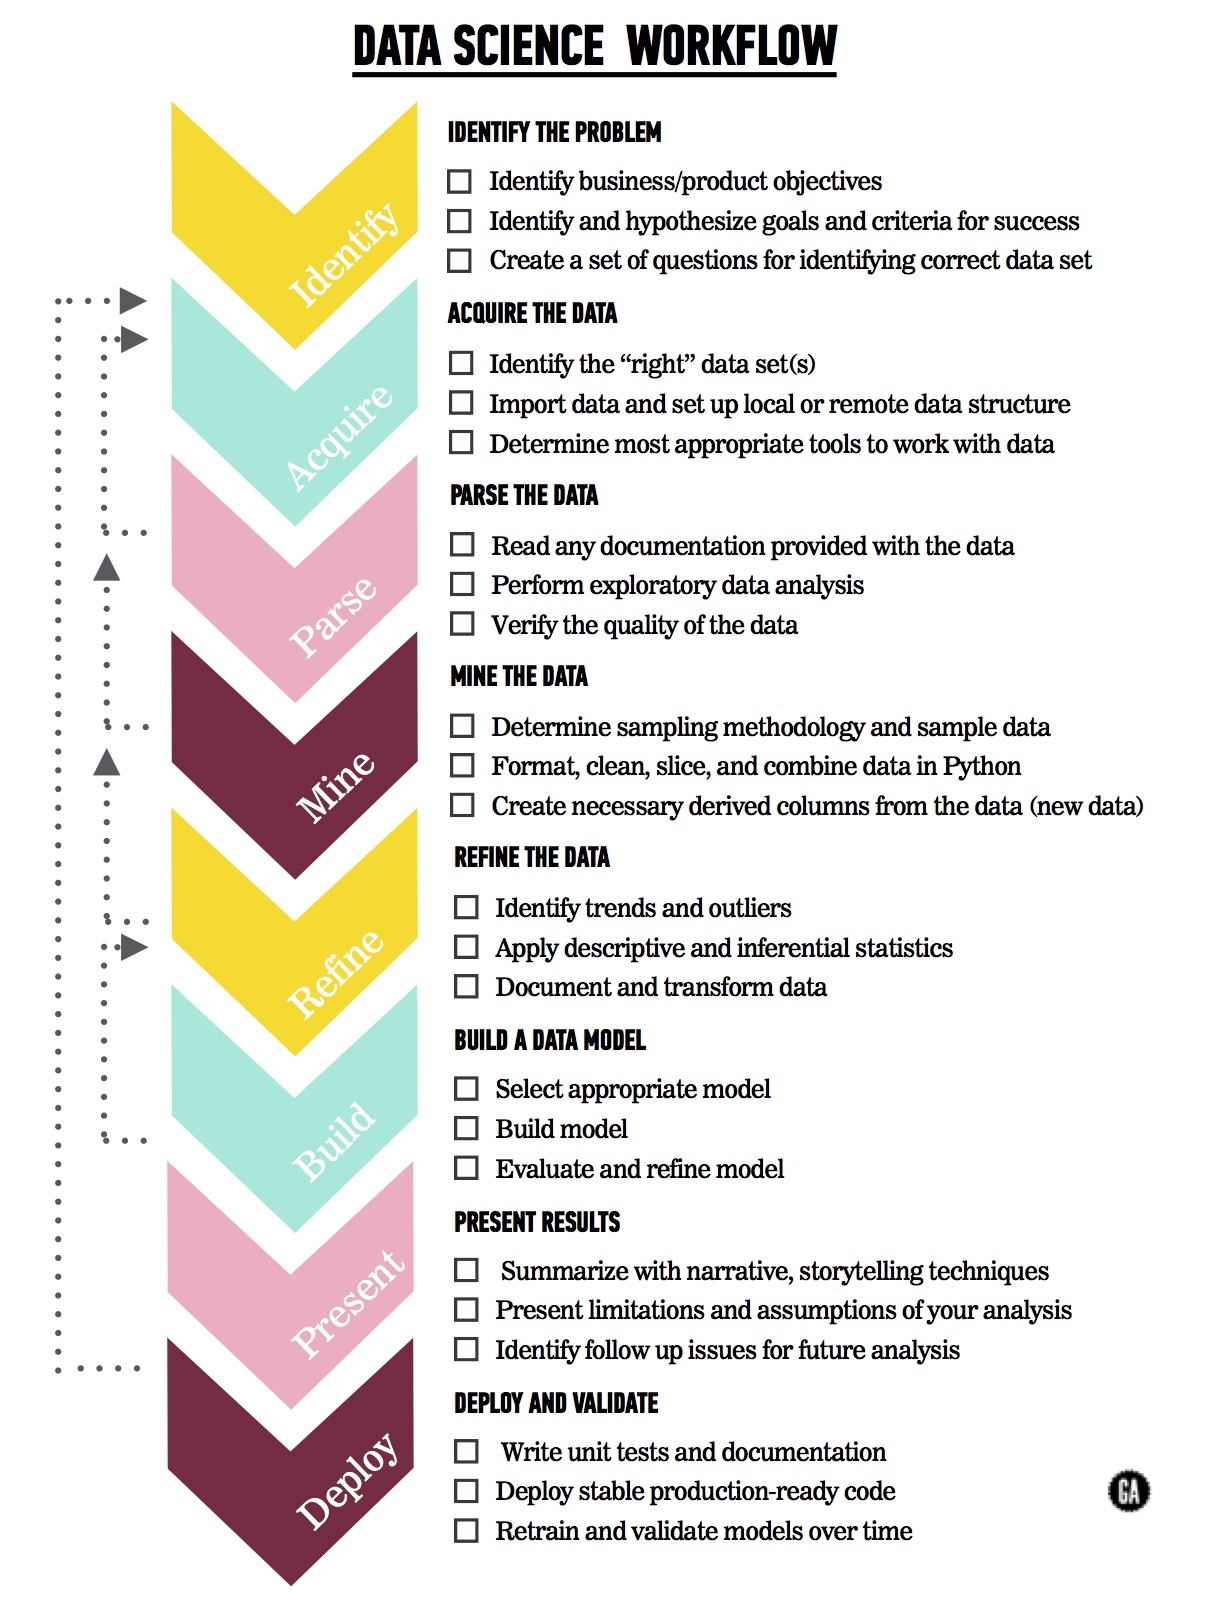

In [1]:
from IPython.display import Image
# change path to where you have the DSI 5 repo stored (I can't do that for you.)
Image(filename='/Users/Alexander/DSI-SF-5/ds_workflow.jpg') 

---
<a name="hook"> </a>

## Applications: 

Churn rate is often used in industry to predict, maintain, and increase user retention. 

### Amazon

[Amazon](https://www.fool.com/investing/2016/06/01/amazon-prime-improves-its-customer-retention-rate.aspx) retains more customers than Cosco through their Prime membership.
![](http://www.rokuhelp.com/wp-content/uploads/2017/02/amazon-696x311.png) 

### Uber
[Uber](http://www.sfchronicle.com/business/article/Uber-incentives-aim-to-lure-power-drivers-7089842.php) creates new incentive programs in order to help maintain driver retention. 
![](http://www.techproducts.com.ng/wp-content/uploads/2016/06/uber-serp-logo-f6e7549c89-660x330.jpg)

---
## **Lesson**
<a name="content"></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.stats.weightstats import ttest_ind
from __future__ import division
from cross_val_tool import cross_validation

%matplotlib inline

# modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale, MinMaxScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter

# gridsearch
import os
from time import sleep
from pprint import pprint
from sklearn.datasets import load_files
from sklearn.cross_validation import  ShuffleSplit
from sklearn.grid_search import ParameterGrid
from ipyparallel import Client
from sklearn.externals import joblib

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Import and clean data 

Perform the same cleaning and scaling as we did in the first churn case study. 

In [3]:
# import data
data_path = "~/DSI-SF-5/datasets/churn.csv"
df = pd.read_csv(data_path)

# drop irrelavent columns like zip code and user phone number
relavent_cols = df.columns[4:]
df = df[relavent_cols]

# replace any positve categorical with 1 
true = ["yes",
        "True",
        "True."]
# replace any negative categorical with 0
false = ["no",
         "False",
         "False."]

df.replace(to_replace=true, value=1, inplace=True)
df.replace(to_replace=false, value=0, inplace=True)

# rename churn column
df.rename(columns={'Churn?':'Churn'}, 
          inplace=True)

# before scaling, exclude the categorical features
numerical_cols = df.columns[2:-1]

# columns won't rescale unless dtype = "float"
df2 = df[numerical_cols].astype(float)


# scale along the features
df2[numerical_cols] = df2[numerical_cols].apply(lambda x: MinMaxScaler(feature_range=(-1,1)).fit_transform(x));

# Move columns with boolean values back into dataframe
df2[df.columns[0]] = df[df.columns[0]].values
df2[df.columns[1]] = df[df.columns[1]].values
df2[df.columns[-1]] = df[df.columns[-1]].values

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your d

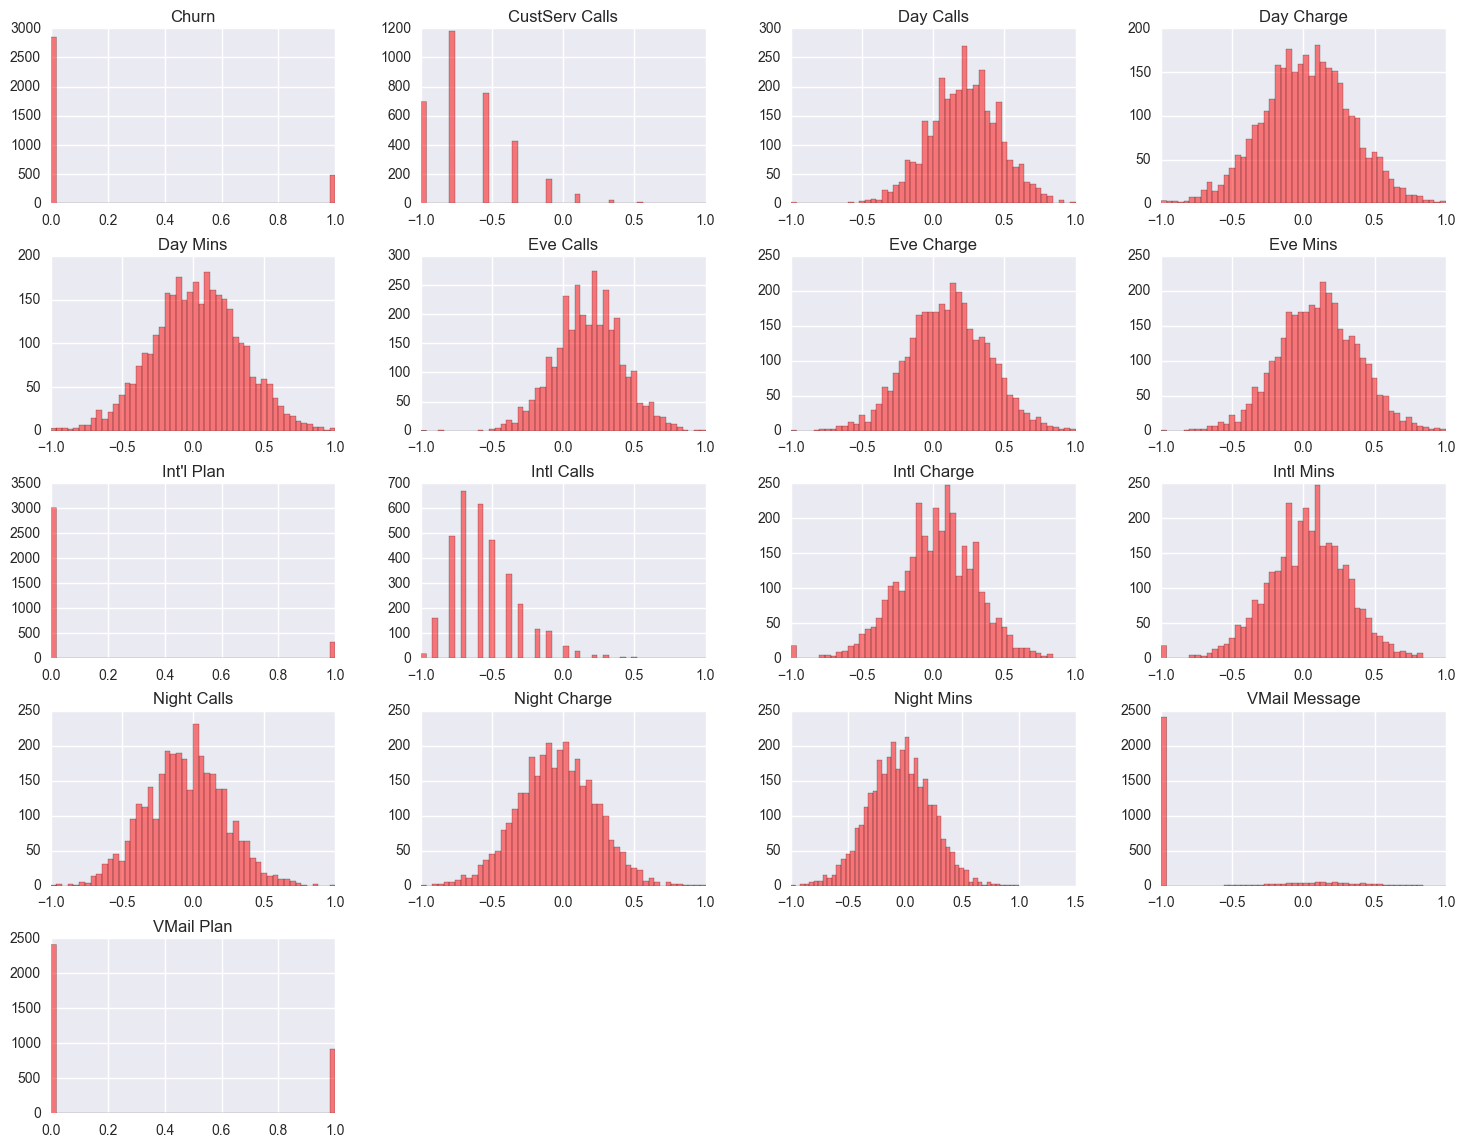

In [4]:
# Distribution of features - after rescaling
df2.hist(color='r', alpha=0.5, bins=50, figsize=(18, 14));

In [5]:
df2.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan,VMail Plan,Churn
0,-0.019608,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778,0,1,0
1,0.019608,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778,0,1,0
2,-1.000000,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000,0,0,0
3,-1.000000,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556,1,0,0
4,-1.000000,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333,1,0,0


## Optimize Models using Gridsearch

We'll be using a custom build gridserach to optimize our models. This version is faster than Sklearn's implementation because this version persist read-only files of the data into memory, while Sklearn's gridsearch has to read the data from hard disk every single time it cross validates a parameter combination. 

**Check out this supplemental notebook that dives deeper into** optimizing memory management for [Gridsearch](./Supplemental-Memory-Management.ipynb)

In [9]:
# partition dataframe into a design matrix and response vector
x_cols = df.columns[:-1]
X = df2[x_cols].values
Y = df2.Churn.values

In [10]:
X, Y = shuffle(X, Y)
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size = 0.2, random_state=1234)

In [11]:
# Data Engineering functions used to greatly speed up model optimization 
def persist_cv_splits(X, y, n_cv_iter=3, name='data', suffix="_cv_%03d.pkl", test_size=0.25, random_state=None):
    """Materialize randomized train test splits of a dataset."""

    cv = ShuffleSplit(X.shape[0], 
                      n_iter=n_cv_iter,
                      test_size=test_size, 
                      random_state=random_state)
    
    cv_split_filenames = []

    for i, (train, test) in enumerate(cv):
        
        cv_fold = (X[train], y[train], X[test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        f(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

def compute_evaluation(cv_split_filename, model, params):
    """Function executed by a worker to evaluate a model on a CV split"""
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib
    from sklearn.metrics import f1_score

    X_train, y_train, X_validation, y_validation = joblib.load(
        cv_split_filename, mmap_mode='c')
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    # accuracy
    #validation_score = model.score(X_validation, y_validation)
    
    # f1_score
    validation_score = f1_score(y_validation, y_pred, average = "macro")
    
    return validation_score

def grid_search(lb_view, model, cv_split_filenames, param_grid):
    """Launch all grid search evaluation tasks."""
    all_tasks = []
    all_parameters = list(ParameterGrid(param_grid))
    
    for i, params in enumerate(all_parameters):
        task_for_params = []
        
        for j, cv_split_filename in enumerate(cv_split_filenames):    
            t = lb_view.apply(
                compute_evaluation, cv_split_filename, model, params)
            task_for_params.append(t) 
        
        all_tasks.append(task_for_params)
        
    return all_parameters, all_tasks

def progress(tasks):
    return np.mean([task.ready() for task_group in tasks
                                 for task in task_group])

def find_bests(all_parameters, all_tasks, n_top=5):
    """Compute the mean score of the completed tasks"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
        
    
    try: 
        mean_scores = np.array(mean_scores)
        sorted_ind = np.argsort(mean_scores.T[0])[::-1]
        return mean_scores[sorted_ind][:n_top]
    
    except IndexError:
        pass

Here we split and persist the training data into memory. 

In [12]:
digits_split_filenames = persist_cv_splits(X_train, Y_train, name='churn-splits', random_state=42)

Next we use the ipyparallel library to create a cluster on the laptop that will allow us to run multiple grid searches simultaneously 

In [29]:
# shut down any pre-existing local clusters
!ipcluster stop
sleep(3)
# start a local cluster with 3 nodes
!ipcluster start -n=3 --daemon
sleep(8)
# create a client to send commands to the cluster
client = Client();
sleep(8)
print ("Number of worker nodes in cluser {}".format(len(client)))

2017-02-28 15:11:13.784 [IPClusterStop] CRITICAL | Could not read pid file, cluster is probably not running.
Number of worker nodes in cluser 3


We are going to optimize two machine learning models Random Forest and Gradient Boosted Trees. Both models have excellent features that we'll discuss shortly. 

In [30]:
# instatiate model
rfc = RandomForestClassifier()
# fill a dictionary with different values for each hyper-parameter
rfc_params = {'max_depth': [None, 4, 8, 12],
              'min_samples_split': [2,6,10],
             'max_leaf_nodes': [None, 4, 8, 12]}

In [31]:
lb_view = client.load_balanced_view()
all_parameters, all_tasks = grid_search(lb_view, 
                                        rfc, 
                                        digits_split_filenames, 
                                        rfc_params)

In [35]:
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
print(find_bests(all_parameters, all_tasks))

Tasks completed: 100.0%
[[0.8989093399773348
  {'min_samples_split': 6, 'max_leaf_nodes': None, 'max_depth': None}]
 [0.89496406493697556
  {'min_samples_split': 2, 'max_leaf_nodes': None, 'max_depth': 12}]
 [0.88816824330349908
  {'min_samples_split': 10, 'max_leaf_nodes': None, 'max_depth': None}]
 [0.88449773725319636
  {'min_samples_split': 10, 'max_leaf_nodes': None, 'max_depth': 12}]
 [0.88039590411934976
  {'min_samples_split': 6, 'max_leaf_nodes': None, 'max_depth': 12}]]


The print out shows that the parameters in the top row lead to the hightest F1 score for Random Forest

In [36]:
# instatiate model
gbt = GradientBoostingClassifier()
# fill a dictionary with different values for each hyper-parameter
gbt_params = {'max_depth': [None, 4, 8, 10],
              'min_samples_split': [2,6,10],
             'max_leaf_nodes': [None, 4, 8, 12],
              "learning_rate" : [0.01, 0.1]}

In [37]:
lb_view = client.load_balanced_view()
all_parameters, all_tasks = grid_search(lb_view, 
                                        gbt, 
                                        digits_split_filenames, 
                                        gbt_params)

In [40]:
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
print(find_bests(all_parameters, all_tasks))

Tasks completed: 100.0%
[[0.91498757075194381
  {'min_samples_split': 2, 'max_leaf_nodes': None, 'learning_rate': 0.1, 'max_depth': 8}]
 [0.91430046102195306
  {'min_samples_split': 2, 'max_leaf_nodes': 8, 'learning_rate': 0.1, 'max_depth': 4}]
 [0.91335161561876055
  {'min_samples_split': 10, 'max_leaf_nodes': 12, 'learning_rate': 0.1, 'max_depth': 8}]
 [0.91278028284339052
  {'min_samples_split': 10, 'max_leaf_nodes': 8, 'learning_rate': 0.1, 'max_depth': 4}]
 [0.91276238888384775
  {'min_samples_split': 2, 'max_leaf_nodes': 8, 'learning_rate': 0.1, 'max_depth': 8}]]


The print out shows that the parameters in the top row lead to the hightest F1 score for Random Forest

In [41]:
# stop cluster
!ipcluster stop

2017-02-28 15:17:33.885 [IPClusterStop] Stopping cluster [pid=3004] with [signal=2]


## Cross Valdiate Models 

Let's fit each model with the unbalanced data set to see how it performance. 

### Logistic Regression

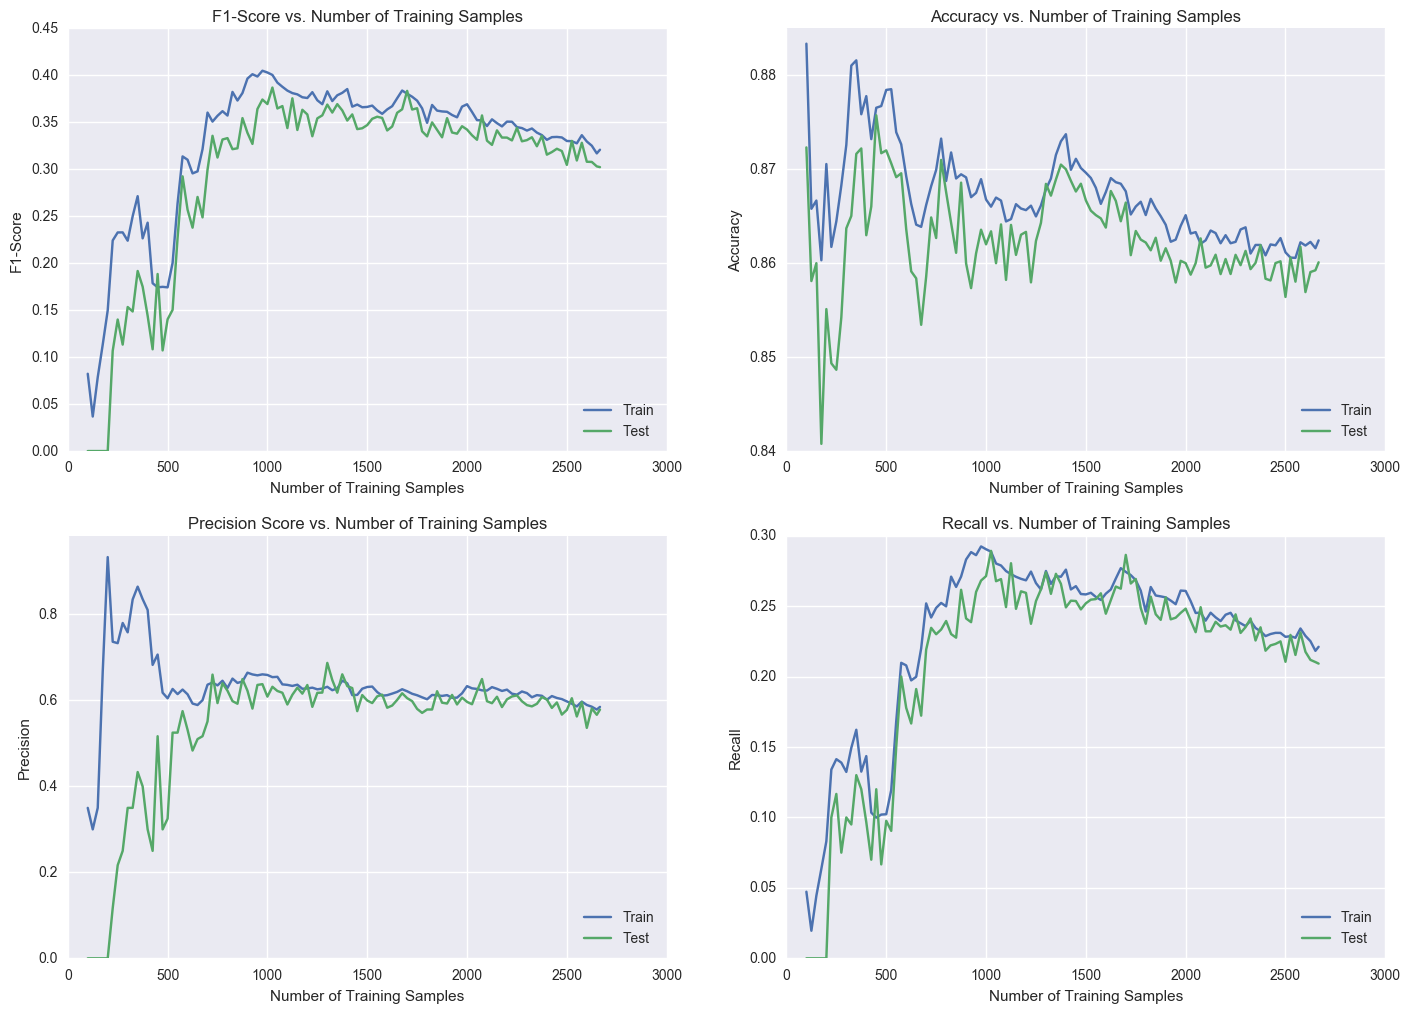

In [42]:
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, X_train, Y_train , n_splits=10,init_chunk_size = 100, chunk_spacings = 25, average = "binary")
cv.train_for_learning_curve()
cv.plot_learning_curve()

### Random Forest

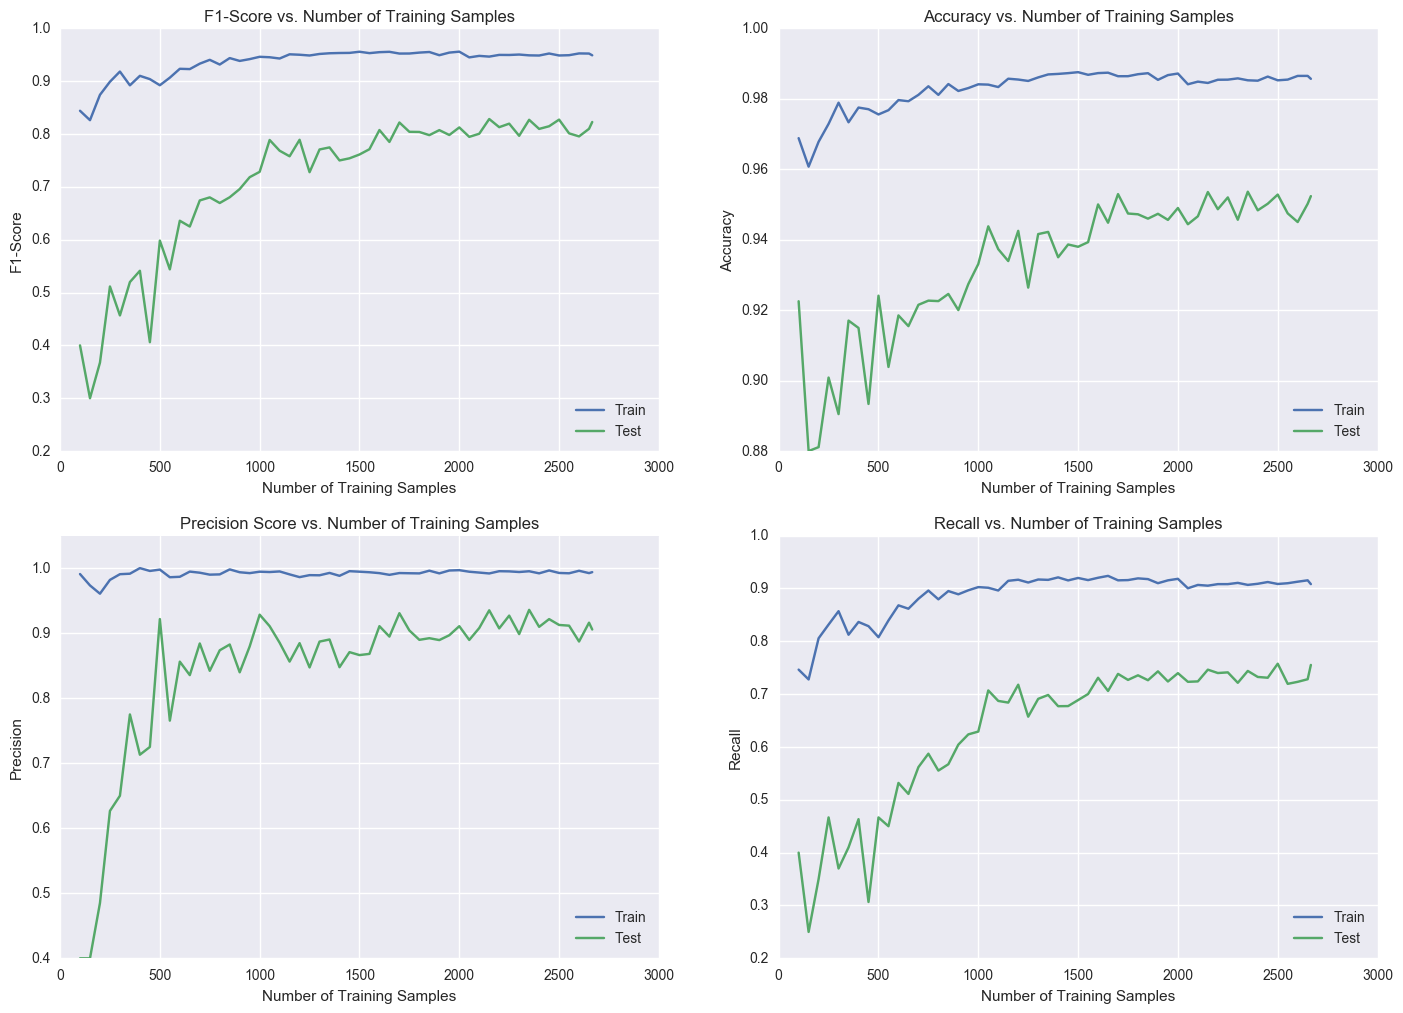

In [50]:
rfc = RandomForestClassifier(min_samples_split = 6, max_leaf_nodes = None, max_depth = None)
cv_rfc = cross_validation(rfc, X_train, Y_train , n_splits=10,init_chunk_size = 100, chunk_spacings = 50, average = "binary")
cv_rfc.train_for_learning_curve()
cv_rfc.plot_learning_curve()

### Gradient Boosted Trees

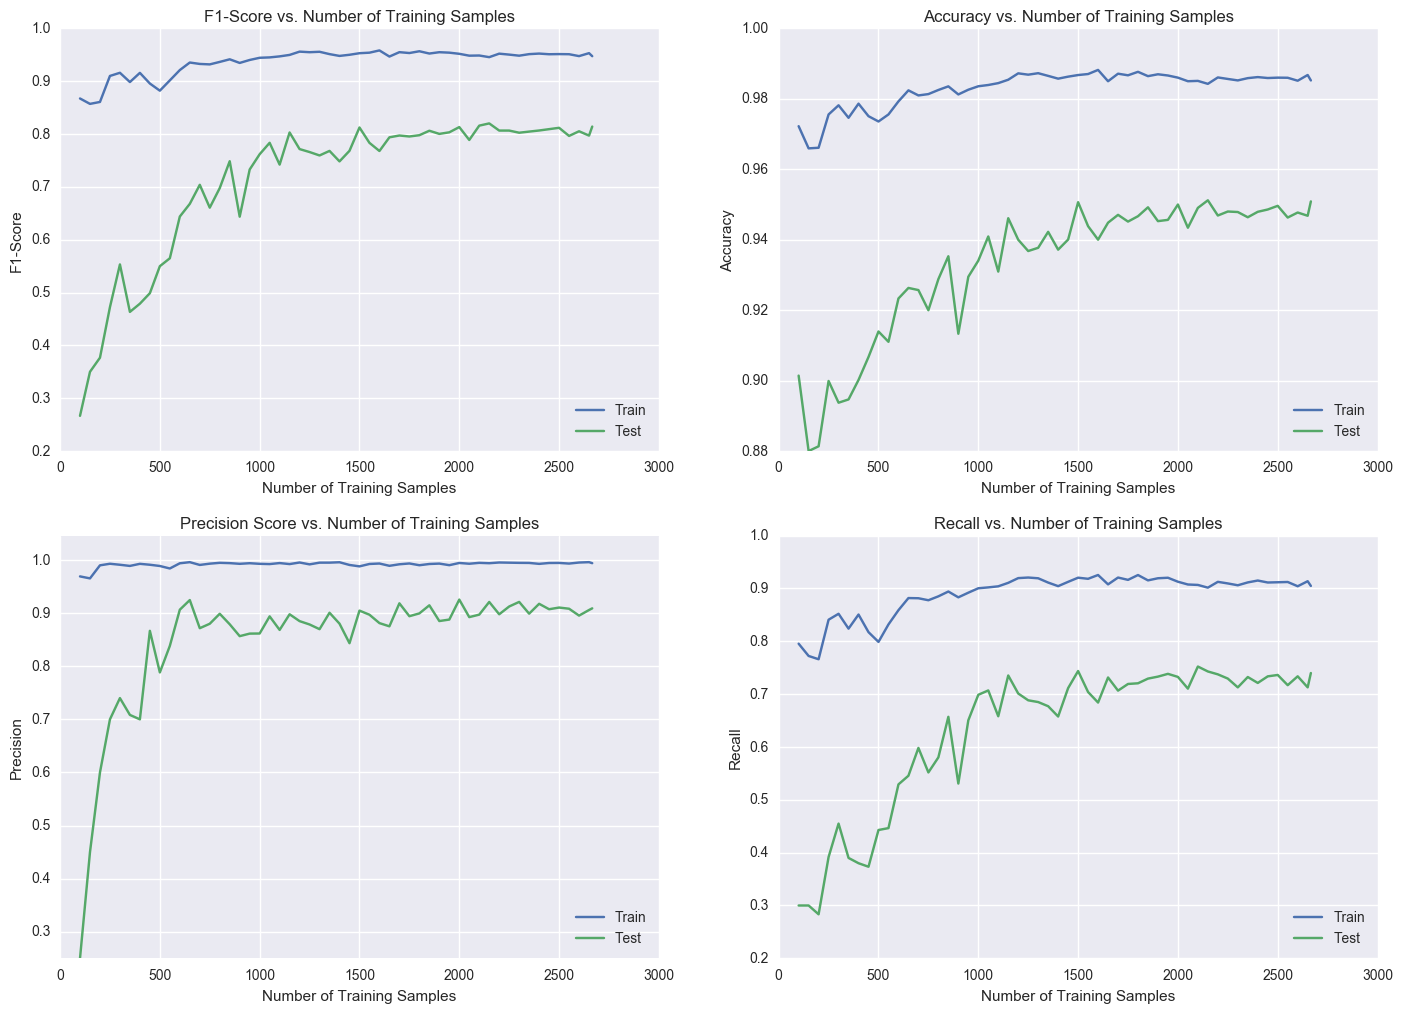

In [51]:
gbt = GradientBoostingClassifier(min_samples_split = 2, max_leaf_nodes = None, learning_rate = 0.1, max_depth = 8)
cv_gbt = cross_validation(rfc, X_train, Y_train , n_splits=10, init_chunk_size = 100, chunk_spacings = 50, average = "binary")
cv_gbt.train_for_learning_curve()
cv_gbt.plot_learning_curve()

## ROC Cruves

Let's plot the roc curves of all three models on the same viz and compare their performance. 

In [120]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, Y_train)
y_lr_prob = lr.predict_proba(X_test)

rfc = RandomForestClassifier(min_samples_split = 6, max_leaf_nodes = None, max_depth = None)
rfc.fit(X_train, Y_train)
y_rfc_prob = rfc.predict_proba(X_test)

gbt = GradientBoostingClassifier(min_samples_split = 2, max_leaf_nodes = None, learning_rate = 0.1, max_depth = 8)
gbt.fit(X_train, Y_train)
y_gbt_prob = gbt.predict_proba(X_test)

In [121]:
prob_list = [y_lr_prob, y_rfc_prob, y_gbt_prob]
model_names = ["Logistic", "RF", "GBT"]

In [149]:
def plot_roc_curves(Y_test, prob_list, model_names):
    fpr_list = []
    tpr_list = []
    auc_list = []
    for y_prob in prob_list:

        fpr, tpr, thresholds = roc_curve(Y_test, y_prob.T[1])
        area_under_curve = auc(fpr, tpr)

        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(area_under_curve)

    x = np.arange(0,Y_test.shape[0]+1, Y_test.shape[0])
    y = x


    plt.figure(figsize = (12,5))
    plt.title("ROC Curve")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.xlim(-0.01, 1.01)
    plt.ylim(0,1.01)
    plt.plot(fpr_list[0], tpr_list[0], 'g', label = "{}: AUC = {:.3}".format(model_names[0], auc_list[0]));
    plt.plot(fpr_list[1], tpr_list[1], 'r', label = "{}: AUC = {:.3}".format(model_names[1], auc_list[1]));
    plt.plot(fpr_list[2], tpr_list[2], 'b', label = "{}: AUC = {:.3}".format(model_names[2], auc_list[2]));

    plt.plot(x,y,'--r');
    plt.legend(loc='lower right');

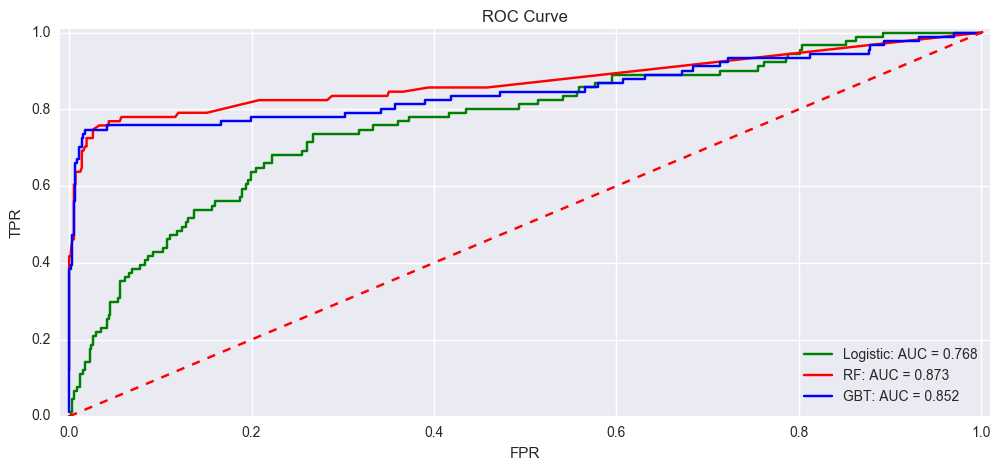

In [150]:
plot_roc_curves(Y_test, prob_list, model_names)

We can see that Random Forest out peforms both Logistic and Gradient Boosted Trees. 

In [152]:
def plot_precision_recall_curves(Y_test):
    precision_list = []
    recall_list = []
    avg_pre_list = []


    for y_prob in prob_list:

        pre, rec, pre_rec_thresholds = precision_recall_curve(Y_test, y_prob.T[1])
        area_under_precision_recall_curve = average_precision_score(Y_test, y_prob.T[1])

        precision_list.append(pre)
        recall_list.append(rec)
        avg_pre_list.append(area_under_precision_recall_curve)

    x = np.arange(0,Y_test.shape[0]+1, Y_test.shape[0])
    y = -1*x


    plt.figure(figsize = (12,5))
    plt.title("Precision Recall Curve")
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.xlim(-0.01, 1.01)
    plt.ylim(0,1.01)
    plt.plot(recall_list[0], precision_list[0], 'g', label = "{}: AUC = {:.3}".format(model_names[0], avg_pre_list[0]));
    plt.plot(recall_list[1], precision_list[1], 'r', label = "{}: AUC = {:.3}".format(model_names[1], avg_pre_list[1]));
    plt.plot(recall_list[2], precision_list[2], 'b', label = "{}: AUC = {:.3}".format(model_names[2], avg_pre_list[2]));

    n_samples = Y_test.shape[0]

    x = np.linspace(0.0, 1.0, n_samples)
    y = np.linspace(1.0, 0, n_samples)
    plt.plot(x, y, '--b', alpha = 0.3)
    plt.legend(loc='upper right');

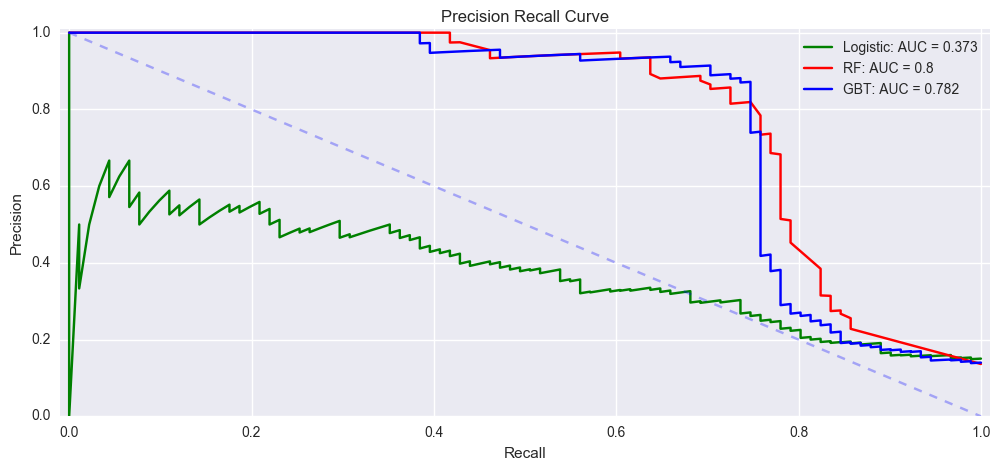

In [153]:
plot_precision_recall_curves(Y_test)

We can see that Logistic's precision recall curve is worest than average. This isn't surprising considing the model's learning curves. We can also see that Random Forest out performs Logistic and Gradient Boosted Trees. Although, there is a narrow range, between 0.65 and 0.75, where GBT slightly out performs RF. 

## Comparing LR and RF on the Holdout set

In [7]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, Y_train)
y_lr_pred = lr.predict(X_test)

print accuracy_score(Y_test, y_lr_pred), precision_score(Y_test, y_lr_pred), recall_score(Y_test, y_lr_pred)

print confusion_matrix(Y_test, y_lr_pred)

0.863568215892 0.611111111111 0.222222222222
[[554  14]
 [ 77  22]]


In [8]:
rfc = RandomForestClassifier(min_samples_split = 6, max_leaf_nodes = None, max_depth = None)
rfc.fit(X_train, Y_train)
y_rfc_pred = rfc.predict(X_test)

print accuracy_score(Y_test, y_rfc_pred), precision_score(Y_test, y_rfc_pred), recall_score(Y_test, y_rfc_pred)

print confusion_matrix(Y_test, y_rfc_pred)

0.950524737631 0.971428571429 0.686868686869
[[566   2]
 [ 31  68]]


The confusion matricies and the metrics built from it show that Random Forest performs significantly better than Logistic Regression. This was acheived with minimual data preperation: scaling values. 

## Feature Importance

Now that we have confirmed that Random Forest has reliable results. Let's use its feature importance method to find out which features are most predictive of churn. Use like Amazon and Uber, we can use information as actionable insight to help retain users and help aquire more users in the future. 

In [63]:
# create array of feture names for ploting
# call the array field_names
field_names = df2.columns.values[:-1]

# create array of feature importance weights from Random Forest
# call the array feat_weights
feat_weights = rfc.feature_importances_

# use np.argsort to get an array of ordered indicies that can be used to 
# sort feature importance weights from largest to smallest
# call the array indices
indices = np.argsort(feats)[::-1]

# Create a list comprehension that collects the feature importance values for every tree in the RF ensemble
# Hint: Use rfc.estimators_
# call the list feat_importance_trees
feat_importance_trees = [tree.feature_importances_ for tree in rfc.estimators_]

# take the standard deviation of this list, this resulting list is the std value for each feature 
# call the array std
std = np.std(feat_importance_trees, axis=0) # std along the column

# create an int variable call n_features that is the numer of features in the feature set
n_features = len(feats)

tick_marks_list = list(range(len(field_names)))

# create an array of sorted feature names
# call the array sorted_feat_names
sorted_feat_names =  np.array(field_names)[indices]

# create an array of soreted std 
# call the array sorted_std
sorted_std = std[indices]

# create an array of sorted feature weights
# call the array sorted_feat_weights
sorted_feat_weights = feat_weights[indices]

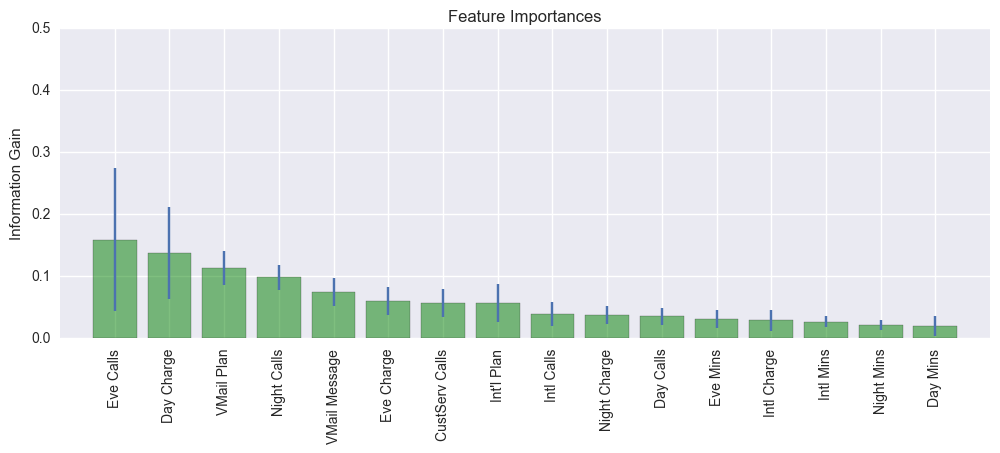

In [64]:
plt.figure(figsize=(12,4))
plt.title("Feature Importances")
plt.ylabel("Information Gain")
plt.bar(list(range(n_features)), sorted_feat_weights, color="g",alpha = 0.5, yerr=sorted_std, align="center")
plt.xticks(tick_marks_list, sorted_feat_names, rotation=90)
plt.xlim([-1, len(field_names)])
plt.ylim([0,0.5]);

### Interpret Results

Recall that Random Forest randomly selects a subset of features to split nodes on, those features that lead to the greatest information gain are used to split the node. If a majority of trees choose feature VMail Message to split the first node in the tree, then that feature is ranked as being most important because it is responsible for the most amount of information gain in the ensemble. 

### Correlation vs. Causality

![](https://imgs.xkcd.com/comics/correlation.png)

The information gain criteria say **NOTHING ABOUT CAUSATION**. In practice we will never know about direct causation between features. This is true because there are always 2nd, 3rd, ..., nth latent features that influence the behavior of a feature. A [latent feature](https://en.wikipedia.org/wiki/Latent_variable) is a hidden feature that influences the outcome of another feature. 

>Latent variables , as opposed to observable variables, are variables that are not directly observed but are rather inferred (through a mathematical model) from other variables that are observed (directly measured).
>--Wikipdia

For this reason we can't be sure that Eve Calls and Day Charges directly cause churn. However, we can still use their importance to turn a profit! But before we can do that, we need to determine if VMail Messages and Day Mins are positively or negativately correlated with churn. For this task we can use Logistic Regression's odds ratio feature. 

In [74]:
# take top k feature given by RF and analyze the odds ratio from LR 
top_k_feats = sorted_feat_names[:5]
X2 = df2[top_k_feats].values

In [71]:
lr = LogisticRegression(penalty='l2')
lr.fit(X2, Y);

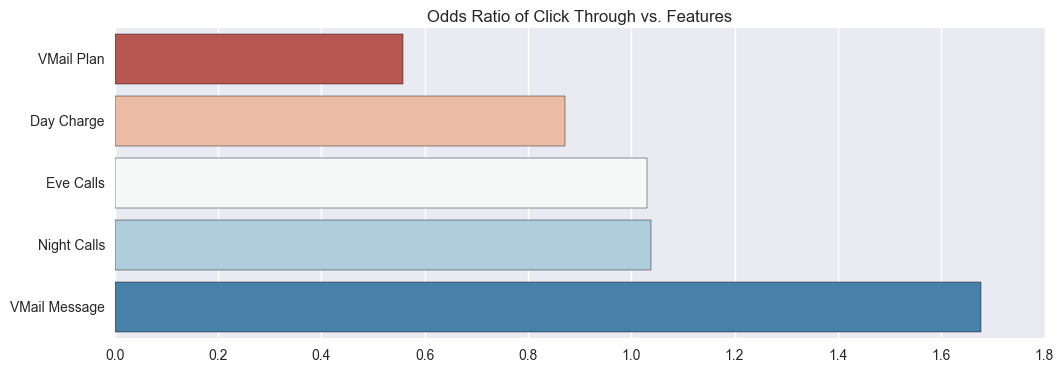

In [80]:
# cut off training to prevent overfitting 
lr = LogisticRegression(penalty='l2');
lr.fit(X2, Y);
# remove nested list
feature_weights = np.exp(lr.coef_[0])

sorted_indicies = np.argsort(feature_weights)

# sort features by odds
sorted_features = feature_weights[sorted_indicies]

plt.figure(figsize = (12,4))
plt.title('Odds Ratio of Click Through vs. Features')
sb.barplot(sorted_features, top_k_feats[sorted_indicies], palette="RdBu");

### Logistic Regression: Interpretation of Feature Weights

We define the odds of Y = 1 as,
$$odds = \frac{P(Y = 1)}{1 - P(Y = 1)} = e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}$$

We interpret the $\beta's$ in multiplicative terms with respect to the odds.

E.g., the interpretation of $\beta_1$ is, holding all the other variables/features fixed, for every increase of 1 in $X_1$, the odds of $Y = 1$ increases by a factor of $e^{\beta_1}$.

Take a look at Night calls and Eve Calls. Their odds ratios are just over 1.0. This means that for every increase of 1 for Night calls and Eve Calls, a costumer is sligtly more likely to churn rathe than not churn. But these results unfortably close to a 1-to-1 odds of churn/not churn. So this model makes a very weak statement about Eve Calls being a directly correlating feature with churn.

Well, those are not very strong statemetns. Keep in mind that Logistic Regression is a very poor performing model with this data set. Unfortunately, this is the only model that we know of that will isolate the effect of a single predictor on the response variable. 

The Day Charge feature is telling us that for every increase of 1 in day charges, 4 times out of 5 times a customer will churn. We can work with these odds. 

### Testing for Effect

The good news is that we can test this statement. We can design an experiment in which coupons are sent to cosmters with high day time charges. We would have to create a threshold, create a cost/benefit matrix, and plot a profit curve to know what portion of the population classied as positive for churn we need to send coupons to to maximize profits. 

The previous [churn case study](./5.1-Classification-Review-and-Case-Study-Churn-Problem.ipynb) gives an example of how to create such an experiment. After running such an experiment and collecting a statistically significant number of samples, we can then run an A/B test to determine if the coupon had any statistically significant impact in decreasing churn. 

---
## Conclusion
<a name="conclusion"></a>

In this lesson we covered how to: 

- Plot, analyze,and explain Random Forest's performance on learning curves 
- Plot, analyze,and explain Gradient Boosted Trees'performance on learning curves
- Plot, analyze,and explain Random Forest's performance on ROC and Precision vs. Recall curves 
- Plot, analyze,and explain Gradient Boosted Trees'performance on ROC and Precision vs. Recall curves 

We also explored an alternative implementation of Grid Search that optimizes memory management in order speed up cross validation. 

---
<a name="more"></a>
## Additional Resources

**Check out this supplemental notebook that dives deeper into** optimizing memory management for [Gridsearch](./Supplemental-Memory-Management.ipynb)

